# **URBAN SOUND CLASSIFICATION**

## **1. Load Data**

In [ ]:
!wget https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
!tar -xzf UrbanSound8K.tar.gz


--2025-11-06 09:14:23--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  2.05MB/s    in 47m 19s 

2025-11-06 10:01:46 (2.02 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
import os, pandas as pd

base_dir = "UrbanSound8K"
metadata_path = f"{base_dir}/metadata/UrbanSound8K.csv"

metadata = pd.read_csv(metadata_path)
print("Rows in metadata:", len(metadata))
print("Example row:\n", metadata.head(5))
print("\nAudio folder exists:", os.path.exists(f"{base_dir}/audio"))



Rows in metadata: 8732
Example row:
       slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

Audio folder exists: True


## **2. Install Dependencies**

In [ ]:
import os, pandas as pd, numpy as np
import librosa, librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## **3. Extract MFCC Features from Audio**

In [ ]:
def extract_features(file_path, n_mfcc=40, max_len=130):
    try:
        audio, sr = librosa.load(file_path, sr=None, mono=True)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # pad/truncate MFCCs to fixed length
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        print("Error:", file_path, e)
        return None

In [ ]:
X, y = [], []

print("🔄 Extracting MFCC features...")
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    path = f"{base_dir}/audio/fold{row.fold}/{row.slice_file_name}"
    label = row["classID"]
    features = extract_features(path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ Feature extraction done!")
print("Feature shape:", X.shape)
print("Label shape:", y.shape)


🔄 Extracting MFCC features...


 33%|███▎      | 2850/8732 [01:59<02:36, 37.66it/s]/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 8732/8732 [05:32<00:00, 26.30it/s]


✅ Feature extraction done!
Feature shape: (8732, 40, 130)
Label shape: (8732,)


In [ ]:
# 1. Number of unique classes
num_classes = len(np.unique(y))

# 2. Unique class IDs (the integer labels 0-9)
unique_class_ids = np.unique(y)

# 3. Unique class names (from the metadata, for clear interpretation)
unique_class_names = metadata[['classID', 'class']].drop_duplicates().sort_values('classID')

print(f"Total Number of Classes: {num_classes}")
print("\nClass IDs and Corresponding Names:")
print(unique_class_names.to_string(index=False))

Total Number of Classes: 10

Class IDs and Corresponding Names:
 classID            class
       0  air_conditioner
       1         car_horn
       2 children_playing
       3         dog_bark
       4         drilling
       5    engine_idling
       6         gun_shot
       7       jackhammer
       8            siren
       9     street_music


## **4. Split Dataset**

In [ ]:
scaler = StandardScaler()
X_reshaped = X.reshape(X.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6985, 40, 130, 1) Test shape: (1747, 40, 130, 1)


## **5. CNN Model**

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(np.unique(y)), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 29, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 29, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,376,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473,674 (5.62 MB)

 Trainable params: 1,472,714 (5.62 MB)

 Non-trainable params: 960 (3.75 KB)

## **6. Train and Evaluate Model**

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
history = model.fit(X_train, y_train,validation_split=0.2,epochs=40,
    batch_size=32, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 398ms/step - accuracy: 0.3209 - loss: 2.3688 - val_accuracy: 0.0644 - val_loss: 6.0671 - learning_rate: 0.0010
Epoch 2/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 400ms/step - accuracy: 0.5251 - loss: 1.4679 - val_accuracy: 0.3314 - val_loss: 2.7863 - learning_rate: 0.0010
Epoch 3/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 396ms/step - accuracy: 0.6406 - loss: 1.0864 - val_accuracy: 0.6206 - val_loss: 1.2592 - learning_rate: 0.0010
Epoch 4/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 396ms/step - accuracy: 0.7251 - loss: 0.8012 - val_accuracy: 0.7409 - val_loss: 0.8361 - learning_rate: 0.0010
Epoch 5/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 419ms/step - accuracy: 0.7648 - loss: 0.7011 - val_accuracy: 0.7366 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 6/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 433ms/step - accuracy: 0.8111 - loss: 0.5578 - val_accuracy: 0.7258 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 7/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 391ms/step - accuracy: 0.8

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8317 - loss: 0.6051
✅ Test Accuracy: 0.835


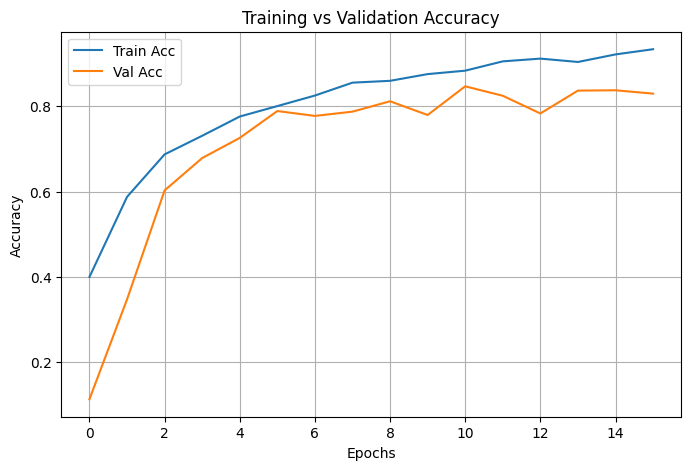

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## **7. Confusion Matrix and Visualization**

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


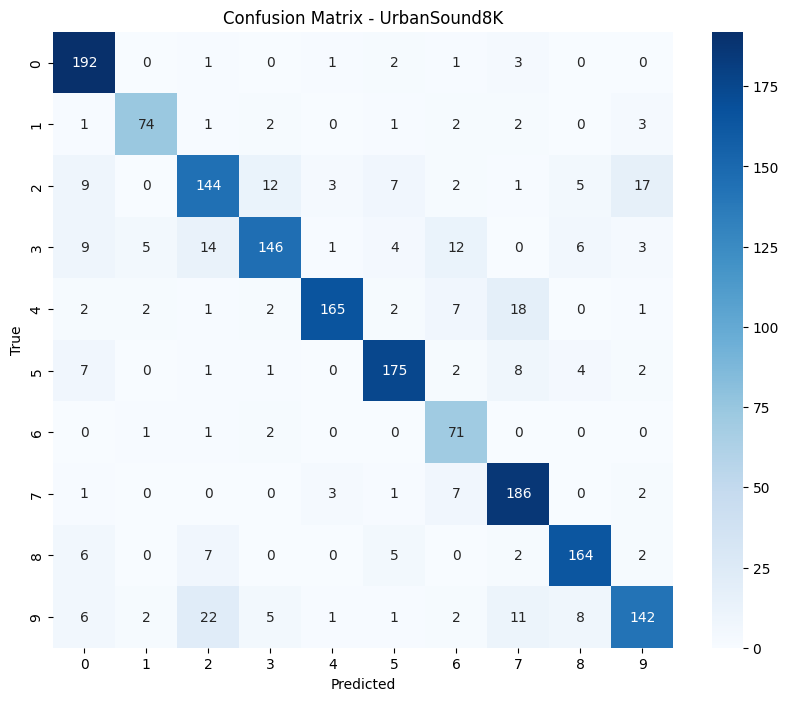

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - UrbanSound8K')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **8.Save Model**

In [ ]:
model.save("UrbanSound_Classifier.h5")

In [ ]:
import IPython.display as ipd
ipd.Audio('/content/UrbanSound8K/audio/fold1/7061-6-0-0.wav')



ValueError: rate must be specified when data is a numpy array or list of audio samples.